In [4]:
import warnings
# Hide the pandas FutureWarnings that pybaseball triggers internally
warnings.filterwarnings("ignore", category=FutureWarning, module=r".*pybaseball.*")
# (Optional) if you still see any date parsing UserWarnings from pandas:
warnings.filterwarnings("ignore", category=UserWarning, message=r"Could not infer format.*")

# Milestone 2 — Data Exploration & Initial Preprocessing (SMALL SCALE, very much a wip)

This notebook fetches MLB data from `pybaseball`, assembles a game-level dataset for the 2023 season (we will expand), explores columns/distributions, and outlines preprocessing for a decision tree model.

**Links:**
- PyPI: https://pypi.org/project/pybaseball/
  
**Environment**: see `requirements.txt` in the repo root.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from pybaseball import schedule_and_record, team_batting, team_pitching, cache
cache.enable()
DATA_DIR = Path('../data/raw'); DATA_DIR.mkdir(parents=True, exist_ok=True)
SEASONS = [2023]
TEAMS = ['ARI','ATL','BAL','BOS','CHC','CHW','CIN','CLE','COL','DET','HOU','KCR','LAA','LAD','MIA','MIL','MIN','NYM','NYY','OAK','PHI','PIT','SDP','SEA','SFG','STL','TBR','TEX','TOR','WSN']
print(f"Seasons: {SEASONS} | Teams: {len(TEAMS)}")


Seasons: [2023] | Teams: 30


## Build a game-level table (home-team perspective)
We pull each team's schedule/results and keep only home games only so each game appears once. The target is `home_win`.


In [ ]:
import pandas as pd
import numpy as np
import re

TEAM_LEAGUE = { # league mapping
    'ARI':'NL','ATL':'NL','BAL':'AL','BOS':'AL','CHC':'NL','CHW':'AL','CIN':'NL','CLE':'AL',
    'COL':'NL','DET':'AL','HOU':'AL','KCR':'AL','LAA':'AL','LAD':'NL','MIA':'NL','MIL':'NL',
    'MIN':'AL','NYM':'NL','NYY':'AL','OAK':'AL','PHI':'NL','PIT':'NL','SDP':'NL','SEA':'AL',
    'SFG':'NL','STL':'NL','TBR':'AL','TEX':'AL','TOR':'AL','WSN':'NL'
}

def _parse_bbref_date(raw_series: pd.Series, season: int) -> pd.Series:
    s = raw_series.astype(str)
    return_str = s.copy()
    s = s.str.replace(r"\(.*?\)", "", regex=True)
    s = s.str.replace(r"^[A-Za-z]{3,9},\s*", "", regex=True)
    s = s.str.strip() + f" {season}"
    dt = pd.to_datetime(s, format="%b %d %Y", errors="coerce")
    m = dt.isna()
    if m.any():
        dt2 = pd.to_datetime(s[m], format="%B %d %Y", errors="coerce")
        dt.loc[m] = dt2
    return dt

def _has_doubleheader(raw_date: pd.Series, gm_num: pd.Series | None = None) -> pd.Series:
    has_paren = raw_date.astype(str).str.contains(r"\((1|2)\)")
    if gm_num is not None:
        try:
            gm_num_int = pd.to_numeric(gm_num, errors="coerce")
            return has_paren | (gm_num_int.fillna(0) > 1)
        except Exception:
            pass
    return has_paren

def _parse_time_to_minutes(time_col: pd.Series) -> pd.Series:
    def to_min(x):
        if pd.isna(x):
            return np.nan
        m = re.match(r"^\s*(\d+):(\d{2})\s*$", str(x))
        if m:
            h, mm = int(m.group(1)), int(m.group(2))
            return 60*h + mm
        return np.nan
    return time_col.apply(to_min)

def _parse_day_night(x):
    x = str(x).strip().upper()
    if x in ("D","DAY"):
        return "Day"
    if x in ("N","NIGHT"):
        return "Night"
    return np.nan

def _to_int_safe(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.lower() == "unknown" or s == "":
        return np.nan
    s = s.replace(",", "")
    return pd.to_numeric(s, errors="coerce")

def load_games_for_season(season: int) -> pd.DataFrame:
    rows = []
    for tm in TEAMS:
        df = schedule_and_record(season, tm).copy()

        raw_date = df["Date"].astype(str)

        home_mask = ~df["Home_Away"].astype(str).str.contains("@") #only home games
        df = df[home_mask]

        wl_first = df["W/L"].astype(str).str[0] #only complete games
        df = df[wl_first.isin(["W", "L"])].copy()

        df["date"] = _parse_bbref_date(df["Date"], season)

        df = df.rename(columns={"Tm":"home_team","Opp":"away_team","R":"home_runs","RA":"away_runs"})

        df["home_win"] = (wl_first.loc[df.index] == "W").astype(int)

        # season
        df["season"] = season

        # game number (Gm#) and doubleheader flag
        gm_num = df["Gm#"] if "Gm#" in df.columns else None
        df["game_number"] = pd.to_numeric(gm_num, errors="coerce") if gm_num is not None else np.nan
        df["is_doubleheader"] = _has_doubleheader(raw_date.loc[df.index], gm_num.loc[df.index] if gm_num is not None else None).astype(int)

        # day/night
        dn = df["D/N"] if "D/N" in df.columns else None
        df["day_night"] = dn.map(_parse_day_night) if dn is not None else np.nan

        # attendance (int)
        att = df["Attendance"] if "Attendance" in df.columns else None
        df["attendance"] = att.map(_to_int_safe) if att is not None else np.nan

        # game time in minutes
        time_col = df["Time"] if "Time" in df.columns else None
        df["game_time_minutes"] = _parse_time_to_minutes(time_col) if time_col is not None else np.nan

        # innings / extra innings flag
        inn = df["Inn"] if "Inn" in df.columns else None
        df["innings"] = pd.to_numeric(inn, errors="coerce") if inn is not None else np.nan
        df["is_extra_innings"] = (df["innings"] > 9).astype(float) if "innings" in df else np.nan

        # simple run differential (home perspective)
        df["run_diff"] = df["home_runs"] - df["away_runs"]

        # calendar features
        df["month"] = df["date"].dt.month
        df["weekday"] = df["date"].dt.day_name()

        # league & interleague
        df["home_league"] = df["home_team"].map(TEAM_LEAGUE)
        df["away_league"] = df["away_team"].map(TEAM_LEAGUE)
        df["is_interleague"] = (df["home_league"] != df["away_league"]).astype(int)

        keep_cols = [
            "season","date","home_team","away_team",
            "home_runs","away_runs","home_win","run_diff",
            "game_number","is_doubleheader","day_night","attendance","game_time_minutes",
            "innings","is_extra_innings","month","weekday","home_league","away_league","is_interleague"
        ]
        cols = [c for c in keep_cols if c in df.columns]
        rows.append(df[cols])

    out = pd.concat(rows, ignore_index=True)
    out = out[out["date"].notna()]
    out = out.drop_duplicates(subset=["date","home_team","away_team","home_runs","away_runs"])
    return out.sort_values("date").reset_index(drop=True)

games = pd.concat([load_games_for_season(y) for y in SEASONS], ignore_index=True)
print(games.shape)
games.head()


/var/folders/zj/wg5c8ngn6j32wt_qg9x5p9bc0000gn/T/ipykernel_60792/140098330.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  has_paren = raw_date.astype(str).str.contains(r"\((1|2)\)")
/var/folders/zj/wg5c8ngn6j32wt_qg9x5p9bc0000gn/T/ipykernel_60792/140098330.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  has_paren = raw_date.astype(str).str.contains(r"\((1|2)\)")
/var/folders/zj/wg5c8ngn6j32wt_qg9x5p9bc0000gn/T/ipykernel_60792/140098330.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  has_paren = raw_date.astype(str).str.contains(r"\((1|2)\)")
/var/folders/zj/wg5c8ngn6j32wt_qg9x5p9bc0000gn/T/ipykernel_60792/140098330.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups.

(2429, 20)


,season,date,home_team,away_team,home_runs,away_runs,home_win,run_diff,game_number,is_doubleheader,day_night,attendance,game_time_minutes,innings,is_extra_innings,month,weekday,home_league,away_league,is_interleague
0,2023,2023-03-30,BOS,BAL,9.0,10.0,0,-1.0,NaN,0,Day,36049.0,190,9.0,0.0,3,Thursday,AL,AL,0
1,2023,2023-03-30,NYY,SFG,5.0,0.0,1,5.0,NaN,0,Day,46172.0,153,9.0,0.0,3,Thursday,AL,NL,1
2,2023,2023-03-30,LAD,ARI,8.0,2.0,1,6.0,NaN,0,Night,52075.0,155,9.0,0.0,3,Thursday,NL,NL,0
3,2023,2023-03-30,OAK,LAA,2.0,1.0,1,1.0,NaN,0,Night,26805.0,150,9.0,0.0,3,Thursday,AL,AL,0
4,2023,2023-03-30,KCR,MIN,0.0,2.0,0,-2.0,NaN,0,Day,38351.0,152,9.0,0.0,3,Thursday,AL,AL,0


### Summary: rows, columns, duplicates, missing values


In [5]:
print('Rows:', len(games), ' Columns:', games.shape[1])
print('\nDtypes:')
print(games.dtypes)
print('\nMissing by column:')
print(games.isna().sum())
dupes = games.duplicated(subset=['date','home_team','away_team']).sum()
print(f"\nDuplicate (date, home, away) rows: {dupes}")


Rows: 2429  Columns: 20

Dtypes:
season                        int64
date                 datetime64[ns]
home_team                    object
away_team                    object
home_runs                   float64
away_runs                   float64
home_win                      int64
run_diff                    float64
game_number                 float64
is_doubleheader               int64
day_night                    object
attendance                  float64
game_time_minutes             int64
innings                     float64
is_extra_innings            float64
month                         int32
weekday                      object
home_league                  object
away_league                  object
is_interleague                int64
dtype: object

Missing by column:
season                  0
date                    0
home_team               0
away_team               0
home_runs               0
away_runs               0
home_win                0
run_diff                0
game_

## Merge team-level season stats (batting & pitching)


In [6]:
print(team_batting(2023).columns)

Index(['teamIDfg', 'Season', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B', '2B',
       ...
       'maxEV', 'HardHit', 'HardHit%', 'Events', 'CStr%', 'CSW%', 'xBA',
       'xSLG', 'xwOBA', 'L-WAR'],
      dtype='object', length=319)


In [ ]:
ABBR_TO_NAME = { #mapping names to abbrvs, just in case
    'ARI':'Arizona Diamondbacks','ATL':'Atlanta Braves','BAL':'Baltimore Orioles','BOS':'Boston Red Sox',
    'CHC':'Chicago Cubs','CHW':'Chicago White Sox','CIN':'Cincinnati Reds','CLE':'Cleveland Guardians',
    'COL':'Colorado Rockies','DET':'Detroit Tigers','HOU':'Houston Astros','KCR':'Kansas City Royals',
    'LAA':'Los Angeles Angels','LAD':'Los Angeles Dodgers','MIA':'Miami Marlins','MIL':'Milwaukee Brewers',
    'MIN':'Minnesota Twins','NYM':'New York Mets','NYY':'New York Yankees','OAK':'Oakland Athletics',
    'PHI':'Philadelphia Phillies','PIT':'Pittsburgh Pirates','SDP':'San Diego Padres','SEA':'Seattle Mariners',
    'SFG':'San Francisco Giants','STL':'St. Louis Cardinals','TBR':'Tampa Bay Rays','TEX':'Texas Rangers',
    'TOR':'Toronto Blue Jays','WSN':'Washington Nationals'
}
NAME_TO_ABBR = {v: k for k, v in ABBR_TO_NAME.items()}
ALIASES = {'WSH':'WSN','TB':'TBR','SD':'SDP','KC':'KCR','CWS':'CHW','SF':'SFG','AZ':'ARI'}

def normalize_team_key(df: pd.DataFrame, team_col: str = "Team") -> pd.Series:
    vals = df[team_col].astype(str).str.strip().str.replace(r"\s*\(.*\)$", "", regex=True)
    known = set(ABBR_TO_NAME.keys())
    if vals.isin(known).mean() >= 0.9:
        return vals.replace(ALIASES)
    return vals.map(NAME_TO_ABBR)

def team_batting_minimal(season: int) -> pd.DataFrame:
    tb = team_batting(season).copy()
    tb.columns = tb.columns.str.strip()
    if "BA" not in tb.columns and "AVG" in tb.columns:
        tb = tb.rename(columns={"AVG": "BA"})
    if "OPS" not in tb.columns and {"OBP","SLG"}.issubset(tb.columns):
        tb["OPS"] = tb["OBP"] + tb["SLG"]
    keep = [c for c in ["Team","BA","OBP","SLG","OPS","R"] if c in tb.columns]
    tb = tb[keep].rename(columns={"R":"season_runs"})
    tb["team"] = normalize_team_key(tb, "Team")
    return tb[["team","BA","OBP","SLG","OPS","season_runs"]]

def team_pitching_minimal(season: int) -> pd.DataFrame:
    tp = team_pitching(season).copy()
    tp.columns = tp.columns.str.strip()
    keep = [c for c in ["Team","ERA","WHIP"] if c in tp.columns]
    tp = tp[keep]
    tp["team"] = normalize_team_key(tp, "Team")
    return tp[["team","ERA","WHIP"]]

bat = pd.concat([team_batting_minimal(y) for y in SEASONS], ignore_index=True)
pit = pd.concat([team_pitching_minimal(y) for y in SEASONS], ignore_index=True)
team_stats = bat.merge(pit, on="team", how="inner")

g = games.merge(team_stats.add_prefix("home_"), left_on="home_team", right_on="home_team", how="left")
g = g.merge(team_stats.add_prefix("away_"), left_on="away_team", right_on="away_team", how="left")

print(g.shape)
print("home_ NaN rate:", g["home_BA"].isna().mean())
print("away_ NaN rate:", g["away_BA"].isna().mean())
g.head()


(2429, 34)
home_ NaN rate: 0.0
away_ NaN rate: 0.0


,season,date,home_team,away_team,home_runs,away_runs,home_win,run_diff,game_number,is_doubleheader,...,home_season_runs,home_ERA,home_WHIP,away_BA,away_OBP,away_SLG,away_OPS,away_season_runs,away_ERA,away_WHIP
0,2023,2023-03-30,BOS,BAL,9.0,10.0,0,-1.0,NaN,0,...,772,4.52,1.34,0.255,0.321,0.421,0.742,807,3.91,1.24
1,2023,2023-03-30,NYY,SFG,5.0,0.0,1,5.0,NaN,0,...,673,3.97,1.24,0.235,0.312,0.383,0.695,674,4.02,1.25
2,2023,2023-03-30,LAD,ARI,8.0,2.0,1,6.0,NaN,0,...,906,4.06,1.20,0.250,0.322,0.408,0.730,746,4.48,1.32
3,2023,2023-03-30,OAK,LAA,2.0,1.0,1,1.0,NaN,0,...,585,5.48,1.52,0.245,0.317,0.426,0.743,739,4.64,1.42
4,2023,2023-03-30,KCR,MIN,0.0,2.0,0,-2.0,NaN,0,...,676,5.17,1.41,0.243,0.326,0.428,0.753,778,3.87,1.20


## Recent form: rolling last-10 win percentage (no leakage)


In [8]:
def rolling_win_pct(df_sched: pd.DataFrame, team_col='home_team') -> pd.DataFrame:
    out = []
    for tm, sub in df_sched.groupby(team_col, sort=False):
        sub = sub.sort_values('date').copy()
        sub['win'] = sub['home_win']
        sub['roll10_win_pct'] = sub['win'].rolling(10, min_periods=1).mean().shift(1)
        out.append(sub)
    return pd.concat(out, ignore_index=True)
g = rolling_win_pct(g)
g[['home_team','date','home_win','roll10_win_pct']].head(12)


,home_team,date,home_win,roll10_win_pct
0,BOS,2023-03-30,0,NaN
1,BOS,2023-04-01,1,0.000000
2,BOS,2023-04-02,1,0.500000
3,BOS,2023-04-03,0,0.666667
4,BOS,2023-04-04,0,0.500000
5,BOS,2023-04-05,0,0.400000
6,BOS,2023-04-14,1,0.333333
7,BOS,2023-04-15,1,0.428571
8,BOS,2023-04-16,1,0.500000
9,BOS,2023-04-17,0,0.555556


## Quick EDA


Home win rate: 0.521


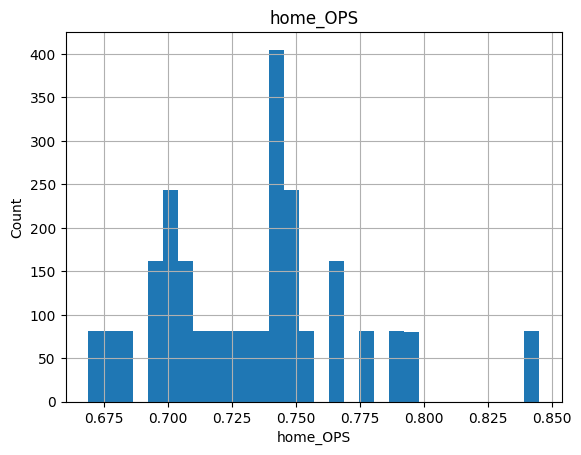

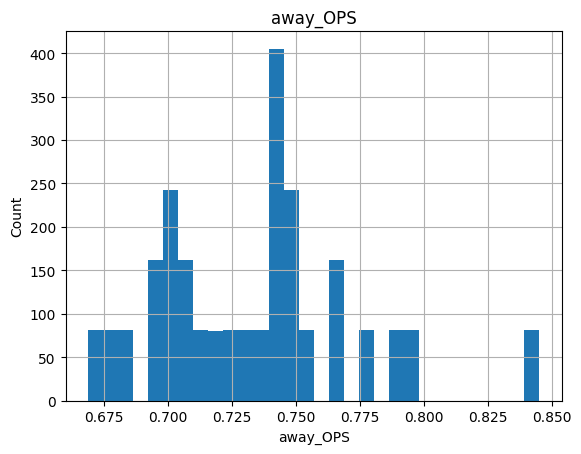

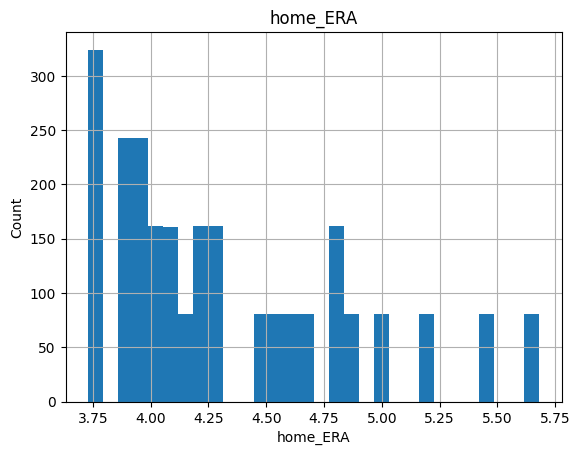

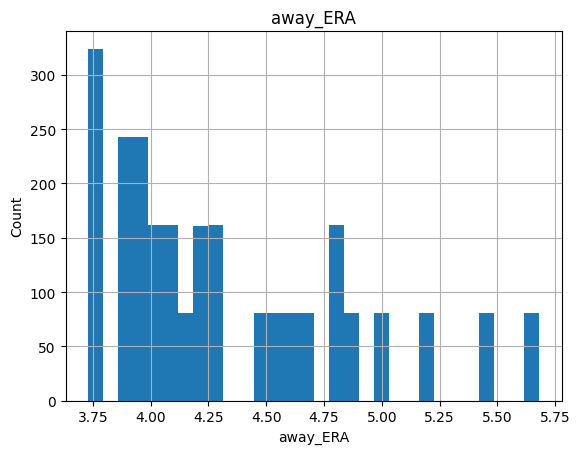

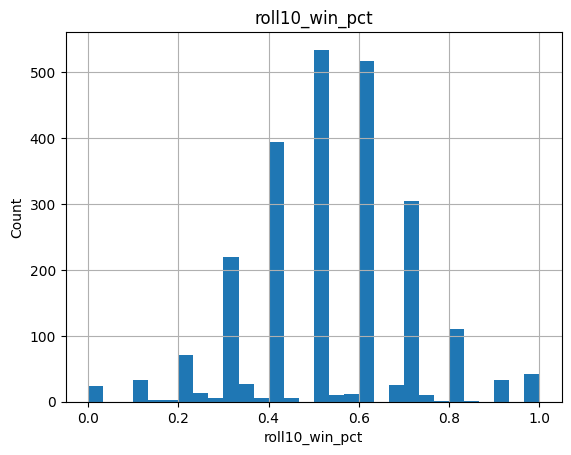

In [9]:
home_rate = g['home_win'].mean(); print(f"Home win rate: {home_rate:.3f}")
for col in ['home_OPS','away_OPS','home_ERA','away_ERA','roll10_win_pct']:
    if col in g.columns:
        plt.figure(); g[col].dropna().hist(bins=30)
        plt.title(col); plt.xlabel(col); plt.ylabel('Count'); plt.show()


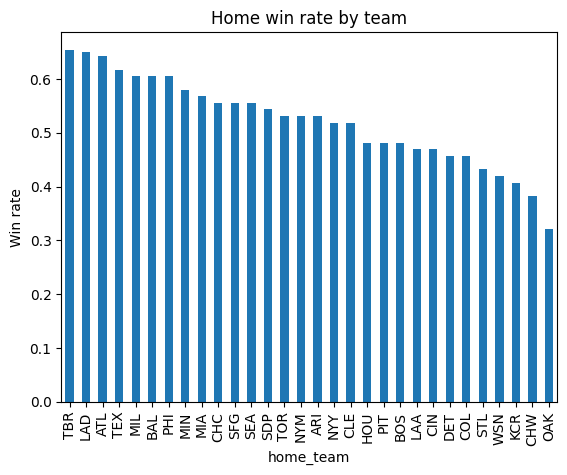

In [10]:
team_win = g.groupby('home_team')['home_win'].mean().sort_values(ascending=False)
plt.figure(); team_win.plot(kind='bar'); plt.title('Home win rate by team'); plt.ylabel('Win rate'); plt.show()


/var/folders/zj/wg5c8ngn6j32wt_qg9x5p9bc0000gn/T/ipykernel_60792/3408640139.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_by_ops = g.dropna(subset=['home_OPS']).groupby(bins)['home_win'].mean()


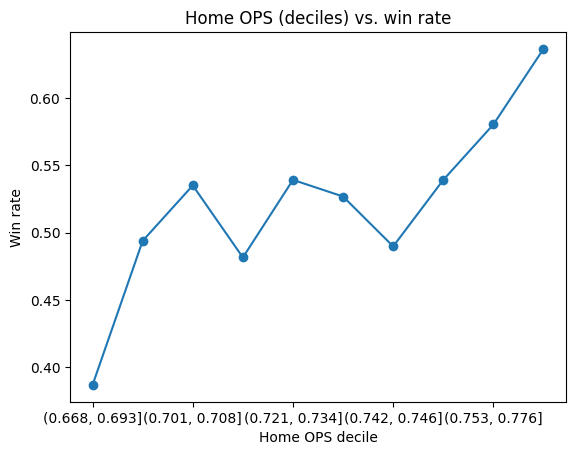

In [11]:
if 'home_OPS' in g.columns:
    bins = pd.qcut(g['home_OPS'].dropna(), q=10, duplicates='drop')
    win_by_ops = g.dropna(subset=['home_OPS']).groupby(bins)['home_win'].mean()
    plt.figure(); win_by_ops.plot(marker='o'); plt.title('Home OPS (deciles) vs. win rate'); plt.xlabel('Home OPS decile'); plt.ylabel('Win rate'); plt.show()


## CSV snapshot (check size -> we need 10-100 GB total)
- with current specs, will need 20 seasons so expand attributes to include all columns, with all columns we'll need ~5 years; should do 2016–2023 (no 2020 since pandemic), test 2024


In [12]:
out_path = Path('../data/raw') / 'games_2023.csv'
g.to_csv(out_path, index=False); out_path


PosixPath('../data/raw/games_2023.csv')

## Notes for Milestone 3
- We're training a DecisionTreeClassifier with stratified/time-aware splits
- the feature set will include the season-level and rolling features created above (no leakage)
- outputs: report accuracy, precision, recall, etc, and feature importances
